In [2]:
#First out imports
#Lets import some stuff!
from datetime import datetime
import os

import cartopy
import matplotlib.pyplot as plt
from netCDF4 import num2date
import numpy as np
import pyart
import netCDF4
import scipy
import xarray
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cmac import cmac, quicklooks
import copy
import importlib
import pytz

%matplotlib inline

In [38]:
from pyart.config import get_fillvalue, get_field_name, get_metadata
from pyart.correct.phase_proc import smooth_and_trim, snr, construct_A_matrix, construct_B_vectors, LP_solver_cylp, fzl_index
from time import time
from numpy import ma

def det_sys_phase(radar, ncp_lev=0.4, rhohv_lev=0.6,
                  ncp_field=None, rhv_field=None, phidp_field=None):
    """
    Determine the system phase.
    Parameters
    ----------
    radar : Radar
        Radar object for which to determine the system phase.
    ncp_lev :
        Miminum normal coherent power level.  Regions below this value will
        not be included in the phase calculation.
    rhohv_lev :
        Miminum copolar coefficient level.  Regions below this value will not
        be included in the phase calculation.
    ncp_field, rhv_field, phidp_field : str
        Field names within the radar object which represent the normal
        coherent power, the copolar coefficient, and the differential phase
        shift.  A value of None for any of these parameters will use the
        default field name as defined in the Py-ART configuration file.
    Returns
    -------
    sys_phase : float or None
        Estimate of the system phase.  None is not estimate can be made.
    """
    # parse the field parameters
    if ncp_field is None:
        ncp_field = get_field_name('normalized_coherent_power')
    if rhv_field is None:
        rhv_field = get_field_name('cross_correlation_ratio')
    if phidp_field is None:
        phidp_field = get_field_name('differential_phase')

    ncp = radar.fields[ncp_field]['data'][:, 30:]
    rhv = radar.fields[rhv_field]['data'][:, 30:]
    phidp = radar.fields[phidp_field]['data'][:, 30:]
    last_ray_idx = radar.sweep_end_ray_index['data'][0]
    return _det_sys_phase(ncp, rhv, phidp, last_ray_idx, ncp_lev,
                          rhohv_lev)


def _det_sys_phase(ncp, rhv, phidp, last_ray_idx, ncp_lev=0.4,
                   rhv_lev=0.6):
    """ Determine the system phase, see :py:func:`det_sys_phase`. """
    good = False
    phases = []
    for radial in range(last_ray_idx + 1):
        meteo = np.logical_and(ncp[radial, :] > ncp_lev,
                               rhv[radial, :] > rhv_lev)
        mpts = np.where(meteo)
        if len(mpts[0]) > 25:
            good = True
            msmth_phidp = smooth_and_trim(phidp[radial, mpts[0]], 9)
            phases.append(msmth_phidp[0:25].min())
    if not(good):
        return None
    return np.median(phases)



def det_process_range(radar, sweep, fzl, doc=10):
    """
    Determine the processing range for a given sweep.
    Queues the radar and returns the indices which can be used to slice
    the radar fields and select the desired sweep with gates which are
    below a given altitude.
    Parameters
    ----------
    radar : Radar
        Radar object from which ranges will be determined.
    sweep : int
        Sweep (0 indexed) for which to determine processing ranges.
    fzl : float
        Maximum altitude in meters. The determined range will not include
        gates which are above this limit.
    doc : int
        Minimum number of gates which will be excluded from the determined
        range.
    Returns
    -------
    gate_end : int
        Index of last gate below `fzl` and satisfying the `doc` parameter.
    ray_start : int
        Ray index which defines the start of the region.
    ray_end : int
        Ray index which defined the end of the region.
    """

    # determine the index of the last valid gate
    ranges = radar.range['data']
    elevation = radar.fixed_angle['data'][sweep]
    radar_height = radar.altitude['data']
    gate_end = fzl_index(fzl, ranges, elevation, radar_height)
    gate_end = min(gate_end, len(ranges) - doc)

    ray_start = radar.sweep_start_ray_index['data'][sweep]
    ray_end = radar.sweep_end_ray_index['data'][sweep] + 1
    return gate_end, ray_start, ray_end



def unwrap_masked(lon, centered=False, copy=True):
    """
    Unwrap a sequence of longitudes or headings in degrees.
    Parameters
    ----------
    lon : array
        Longtiudes or heading in degress. If masked output will also be
        masked.
    centered : bool, optional
        Center the unwrapping as close to zero as possible.
    copy : bool, optional.
        True to return a copy, False will avoid a copy when possible.
    Returns
    -------
    unwrap : array
        Array of unwrapped longtitudes or headings, in degrees.
    """
    masked_input = ma.isMaskedArray(lon)
    if masked_input:
        fill_value = lon.fill_value
        # masked_invalid loses the original fill_value (ma bug, 2011/01/20)
    lon = np.ma.masked_invalid(lon).astype(float)
    if lon.ndim != 1:
        raise ValueError("Only 1-D sequences are supported")
    if lon.shape[0] < 2:
        return lon
    x = lon.compressed()
    if len(x) < 2:
        return lon
    w = np.zeros(x.shape[0] - 1, int)
    ld = np.diff(x)
    np.putmask(w, ld > 180, -1)
    np.putmask(w, ld < -180, 1)
    x[1:] += (w.cumsum() * 360.0)
    if centered:
        x -= 360 * np.round(x.mean() / 360.0)
    if lon.mask is ma.nomask:
        lon[:] = x
    else:
        lon[~lon.mask] = x
    if masked_input:
        lon.fill_value = fill_value
        return lon
    else:
        return lon.filled(np.nan)


def get_phidp_unf(radar, ncp_lev=0.4, rhohv_lev=0.6, debug=False, ncpts=20,
                  doc=-10, overide_sys_phase=False, sys_phase=-135,
                  nowrap=None, refl_field=None, ncp_field=None,
                  rhv_field=None, phidp_field=None):
    """
    Get Unfolded Phi differential phase
    Parameters
    ----------
    radar : Radar
        The input radar.
    ncp_lev :
        Miminum normal coherent power level.  Regions below this value will
        not be included in the calculation.
    rhohv_lev :
        Miminum copolar coefficient level.  Regions below this value will not
        be included in the calculation.
    debug : bool, optioanl
        True to print debugging information, False to supress printing.
    ncpts : int
        Minimum number of points in a ray.  Regions within a ray smaller than
        this or beginning before this gate number are excluded from
        calculations.
    doc : int or None.
        Index of first gate not to include in field data, None include all.
    overide_sys_phase : bool, optional
        True to use `sys_phase` as the system phase. False will determine a
        value automatically.
    sys_phase : float, optional
        System phase, not used if overide_sys_phase is False.
    nowrap : or None
        Gate number where unwrapping should begin. `None` will unwrap all
        gates.
    refl_field ncp_field, rhv_field, phidp_field : str
        Field names within the radar object which represent the horizonal
        reflectivity, normal coherent power, the copolar coefficient, and the
        differential phase shift. A value of None for any of these parameters
        will use the default field name as defined in the Py-ART
        configuration file.
    Returns
    -------
    cordata : array
        Unwrapped phi differential phase.
    """
    # parse the field parameters
    if refl_field is None:
        refl_field = get_field_name('reflectivity')
    if ncp_field is None:
        ncp_field = get_field_name('normalized_coherent_power')
    if rhv_field is None:
        rhv_field = get_field_name('cross_correlation_ratio')
    if phidp_field is None:
        phidp_field = get_field_name('differential_phase')

    if doc is not None:
        my_phidp = radar.fields[phidp_field]['data'][:, 0:doc]
        my_rhv = radar.fields[rhv_field]['data'][:, 0:doc]
        my_ncp = radar.fields[ncp_field]['data'][:, 0:doc]
        my_z = radar.fields[refl_field]['data'][:, 0:doc]
    else:
        my_phidp = radar.fields[phidp_field]['data']
        my_rhv = radar.fields[rhv_field]['data']
        my_ncp = radar.fields[ncp_field]['data']
        my_z = radar.fields[refl_field]['data']
    t = time()
    if overide_sys_phase:
        system_zero = sys_phase
    else:
        system_zero = det_sys_phase(
            radar, ncp_field=ncp_field, rhv_field=rhv_field,
            phidp_field=phidp_field)
        if system_zero is None:
            system_zero = sys_phase
    cordata = np.zeros(my_rhv.shape, dtype=float)
    for radial in range(my_rhv.shape[0]):
        my_snr = snr(my_z[radial, :])
        notmeteo = np.logical_or(np.logical_or(
            my_ncp[radial, :] < ncp_lev,
            my_rhv[radial, :] < rhohv_lev), my_snr < 10.0)
        x_ma = ma.masked_where(notmeteo, my_phidp[radial, :])
        try:
            ma.notmasked_contiguous(x_ma)
            for slc in ma.notmasked_contiguous(x_ma):
                # so trying to get rid of clutter and small things that
                # should not add to phidp anyway
                if slc.stop - slc.start < ncpts or slc.start < ncpts:
                    x_ma.mask[slc.start - 1:slc.stop + 1] = True
            c = 0
        except TypeError:  # non sequence, no valid regions
            c = 1  # ie do nothing
            x_ma.mask[:] = True
        except AttributeError:
            # sys.stderr.write('No Valid Regions, ATTERR \n ')
            # sys.stderr.write(myfile.times['time_end'].isoformat() + '\n')
            # print x_ma
            # print x_ma.mask
            c = 1  # also do nothing
            x_ma.mask = True
        if 'nowrap' is not None:
            # Start the unfolding a bit later in order to avoid false
            # jumps based on clutter
            unwrapped = copy.deepcopy(x_ma)
            end_unwrap = unwrap_masked(x_ma[nowrap::], centered=False)
            unwrapped[nowrap::] = end_unwrap
        else:
            unwrapped = unwrap_masked(x_ma, centered=False)
        #end so no clutter expected
        system_max = unwrapped[np.where(np.logical_not(
            notmeteo))][-10:-1].mean() - system_zero
        unwrapped_fixed = np.zeros(len(x_ma), dtype=float)
        based = unwrapped-system_zero
        based[0] = 0.0
        notmeteo[0] = False
        based[-1] = system_max
        notmeteo[-1] = False
        unwrapped_fixed[np.where(np.logical_not(based.mask))[0]] = \
            based[np.where(np.logical_not(based.mask))[0]]
        if len(based[np.where(np.logical_not(based.mask))[0]]) > 11:
            unwrapped_fixed[np.where(based.mask)[0]] = \
                np.interp(np.where(based.mask)[0],
                          np.where(np.logical_not(based.mask))[0],
                          smooth_and_trim(based[np.where(
                              np.logical_not(based.mask))[0]]))
        else:
            unwrapped_fixed[np.where(based.mask)[0]] = \
                np.interp(np.where(based.mask)[0],
                          np.where(np.logical_not(based.mask))[0],
                          based[np.where(np.logical_not(based.mask))[0]])
        if c != 1:
            cordata[radial, :] = unwrapped_fixed
        else:
            cordata[radial, :] = np.zeros(my_rhv.shape[1])
    if debug:
        print("Exec time: ", time() - t)
    return cordata


def phase_proc_lp(radar, offset, debug=False, self_const=60000.0,
                  low_z=10.0, high_z=53.0, min_phidp=0.01, min_ncp=0.5,
                  min_rhv=0.8, fzl=4000.0, sys_phase=0.0,
                  overide_sys_phase=False, nowrap=None, really_verbose=False,
                  LP_solver='cylp', refl_field=None, ncp_field=None,
                  rhv_field=None, phidp_field=None, kdp_field=None,
                  unf_field=None, window_len=35, proc=1, coef=0.914):
    """
    Phase process using a LP method [1].
    Parameters
    ----------
    radar : Radar
        Input radar.
    offset : float
        Reflectivity offset in dBz.
    debug : bool, optional
        True to print debugging information.
    self_const : float, optional
        Self consistency factor.
    low_z : float
        Low limit for reflectivity. Reflectivity below this value is set to
        this limit.
    high_z : float
        High limit for reflectivity.  Reflectivity above this value is set to
        this limit.
    min_phidp : float
        Minimum Phi differential phase.
    min_ncp : float
        Minimum normal coherent power.
    min_rhv : float
        Minimum copolar coefficient.
    fzl :
        Maximum altitude.
    sys_phase : float
        System phase in degrees.
    overide_sys_phase: bool.
        True to use `sys_phase` as the system phase.  False will calculate a
        value automatically.
    nowrap : int or None.
        Gate number to begin phase unwrapping.  None will unwrap all phases.
    really_verbose : bool
        True to print LPX messaging. False to suppress.
    LP_solver : 'pyglpk' or 'cvxopt', 'cylp', or 'cylp_mp'
        Module to use to solve LP problem.
    refl_field, ncp_field, rhv_field, phidp_field, kdp_field: str
        Name of field in radar which contains the horizonal reflectivity,
        normal coherent power, copolar coefficient, differential phase shift,
        and differential phase. A value of None for any of these parameters
        will use the default field name as defined in the Py-ART configuration
        file.
    unf_field : str
        Name of field which will be added to the radar object which will
        contain the unfolded differential phase.  Metadata for this field
        will be taken from the phidp_field.  A value of None will use
        the default field name as defined in the Py-ART configuration file.
    window_len : int
        Length of Sobel window applied to PhiDP field when prior to
        calculating KDP.
    proc : int
        Number of worker processes, only used when `LP_solver` is 'cylp_mp'.
    coef : float
        Exponent linking Z to KDP in self consistency. kdp=(10**(0.1z))*coef
    Returns
    -------
    reproc_phase : dict
        Field dictionary containing processed differential phase shifts.
    sob_kdp : dict
        Field dictionary containing recalculated differential phases.
    References
    ----------
    [1] Giangrande, S.E., R. McGraw, and L. Lei. An Application of
    Linear Programming to Polarimetric Radar Differential Phase Processing.
    J. Atmos. and Oceanic Tech, 2013, 30, 1716.
    """
    # parse the field parameters
    if refl_field is None:
        refl_field = get_field_name('reflectivity')
    if ncp_field is None:
        ncp_field = get_field_name('normalized_coherent_power')
    if rhv_field is None:
        rhv_field = get_field_name('cross_correlation_ratio')
    if phidp_field is None:
        phidp_field = get_field_name('differential_phase')
    if kdp_field is None:
        kdp_field = get_field_name('specific_differential_phase')
    if unf_field is None:
        unf_field = get_field_name('unfolded_differential_phase')

    # prepare reflectivity field
    refl = copy.deepcopy(radar.fields[refl_field]['data']) + offset
    is_low_z = (refl) < low_z
    is_high_z = (refl) > high_z
    refl[np.where(is_high_z)] = high_z
    refl[np.where(is_low_z)] = low_z
    z_mod = refl

    # unfold Phi_DP
    if debug:
        print('Unfolding')
    my_unf = get_phidp_unf(radar, ncp_lev=min_ncp, rhohv_lev=min_rhv,
                           debug=debug, ncpts=2, doc=None,
                           sys_phase=sys_phase, nowrap=nowrap,
                           overide_sys_phase=overide_sys_phase,
                           refl_field=refl_field, ncp_field=ncp_field,
                           rhv_field=rhv_field, phidp_field=phidp_field)
    my_new_ph = copy.deepcopy(radar.fields[phidp_field])
    my_unf[:, -1] = my_unf[:, -2]
    my_new_ph['data'] = my_unf
    radar.fields.update({unf_field: my_new_ph})

    phidp_mod = copy.deepcopy(radar.fields[unf_field]['data'])
    phidp_neg = phidp_mod < min_phidp
    phidp_mod[np.where(phidp_neg)] = min_phidp

    # process
    proc_ph = copy.deepcopy(radar.fields[phidp_field])
    proc_ph['data'] = phidp_mod
    St_Gorlv_differential_5pts = [-.2, -.1, 0, .1, .2]
    for sweep in range(len(radar.sweep_start_ray_index['data'])):
        if debug:
            print("Doing ", sweep)
        end_gate, start_ray, end_ray = det_process_range(
            radar, sweep, fzl, doc=15)
        start_gate = 0

        A_Matrix = construct_A_matrix(
            len(radar.range['data'][start_gate:end_gate]),
            St_Gorlv_differential_5pts)

        B_vectors = construct_B_vectors(
            phidp_mod[start_ray:end_ray, start_gate:end_gate],
            z_mod[start_ray:end_ray, start_gate:end_gate],
            St_Gorlv_differential_5pts, dweight=self_const,
            coef=coef)

        weights = np.ones(
            phidp_mod[start_ray:end_ray, start_gate:end_gate].shape)

        nw = np.bmat([weights, np.zeros(weights.shape)])

        if LP_solver == 'pyglpk':
            mysoln = LP_solver_pyglpk(A_Matrix, B_vectors, nw,
                                      really_verbose=really_verbose)
        elif LP_solver == 'cvxopt':
            mysoln = LP_solver_cvxopt(A_Matrix, B_vectors, nw)
        elif LP_solver == 'cylp':
            mysoln = LP_solver_cylp(A_Matrix, B_vectors, nw,
                                    really_verbose=really_verbose)
        elif LP_solver == 'cylp_mp':
            mysoln = LP_solver_cylp_mp(A_Matrix, B_vectors, nw,
                                       really_verbose=really_verbose,
                                       proc=proc)
        else:
            raise ValueError('unknown LP_solver:' + LP_solver)

        proc_ph['data'][start_ray:end_ray, start_gate:end_gate] = mysoln

    last_gates = proc_ph['data'][start_ray:end_ray, -16]
    proc_ph['data'][start_ray:end_ray, -16:] = \
        np.meshgrid(np.ones([16]), last_gates)[1]
    proc_ph['valid_min'] = 0.0          # XXX is this correct?
    proc_ph['valid_max'] = 400.0        # XXX is this correct?

    # prepare output
    sobel = 2. * np.arange(window_len)/(window_len - 1.0) - 1.0
    sobel = sobel/(abs(sobel).sum())
    sobel = sobel[::-1]
    gate_spacing = (radar.range['data'][1] - radar.range['data'][0]) / 1000.
    kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
           ((window_len / 3.0) * 2.0 * gate_spacing))

    # copy the KDP metadata from existing field or create anew
    if kdp_field in radar.fields:
        sob_kdp = copy.deepcopy(radar.fields[kdp_field])
    else:
        sob_kdp = get_metadata(kdp_field)

    sob_kdp['data'] = kdp
    sob_kdp['_FillValue'] = get_fillvalue()

    return proc_ph, sob_kdp

In [37]:

def phase_proc_lp_gf(radar, offset, gatefilter, debug=False, self_const=60000.0,
                  low_z=10.0, high_z=53.0, min_phidp=0.01, min_ncp=0.5,
                  min_rhv=0.8, fzl=4000.0, sys_phase=0.0,
                  overide_sys_phase=False, nowrap=None, really_verbose=False,
                  LP_solver='cylp', refl_field=None, ncp_field=None,
                  rhv_field=None, phidp_field=None, kdp_field=None,
                  unf_field=None, window_len=35, proc=1, coef=0.914, ncpts=None):
    """
    Phase process using a LP method [1].
    Parameters
    ----------
    radar : Radar
        Input radar.
    offset : float
        Reflectivity offset in dBz.
    debug : bool, optional
        True to print debugging information.
    self_const : float, optional
        Self consistency factor.
    low_z : float
        Low limit for reflectivity. Reflectivity below this value is set to
        this limit.
    high_z : float
        High limit for reflectivity.  Reflectivity above this value is set to
        this limit.
    min_phidp : float
        Minimum Phi differential phase.
    min_ncp : float
        Minimum normal coherent power.
    min_rhv : float
        Minimum copolar coefficient.
    fzl :
        Maximum altitude.
    sys_phase : float
        System phase in degrees.
    overide_sys_phase: bool.
        True to use `sys_phase` as the system phase.  False will calculate a
        value automatically.
    nowrap : int or None.
        Gate number to begin phase unwrapping.  None will unwrap all phases.
    really_verbose : bool
        True to print LPX messaging. False to suppress.
    LP_solver : 'pyglpk' or 'cvxopt', 'cylp', or 'cylp_mp'
        Module to use to solve LP problem.
    refl_field, ncp_field, rhv_field, phidp_field, kdp_field: str
        Name of field in radar which contains the horizonal reflectivity,
        normal coherent power, copolar coefficient, differential phase shift,
        and differential phase. A value of None for any of these parameters
        will use the default field name as defined in the Py-ART configuration
        file.
    unf_field : str
        Name of field which will be added to the radar object which will
        contain the unfolded differential phase.  Metadata for this field
        will be taken from the phidp_field.  A value of None will use
        the default field name as defined in the Py-ART configuration file.
    window_len : int
        Length of Sobel window applied to PhiDP field when prior to
        calculating KDP.
    proc : int
        Number of worker processes, only used when `LP_solver` is 'cylp_mp'.
    coef : float
        Exponent linking Z to KDP in self consistency. kdp=(10**(0.1z))*coef
    Returns
    -------
    reproc_phase : dict
        Field dictionary containing processed differential phase shifts.
    sob_kdp : dict
        Field dictionary containing recalculated differential phases.
    References
    ----------
    [1] Giangrande, S.E., R. McGraw, and L. Lei. An Application of
    Linear Programming to Polarimetric Radar Differential Phase Processing.
    J. Atmos. and Oceanic Tech, 2013, 30, 1716.
    """
    # parse the field parameters
    if refl_field is None:
        refl_field = get_field_name('reflectivity')
    if ncp_field is None:
        ncp_field = get_field_name('normalized_coherent_power')
    if rhv_field is None:
        rhv_field = get_field_name('cross_correlation_ratio')
    if phidp_field is None:
        phidp_field = get_field_name('differential_phase')
    if kdp_field is None:
        kdp_field = get_field_name('specific_differential_phase')
    if unf_field is None:
        unf_field = get_field_name('unfolded_differential_phase')

    # prepare reflectivity field
    refl = copy.deepcopy(radar.fields[refl_field]['data']) + offset
    is_low_z = (refl) < low_z
    is_high_z = (refl) > high_z
    refl[np.where(is_high_z)] = high_z
    refl[np.where(is_low_z)] = low_z
    z_mod = refl

    # unfold Phi_DP
    if debug:
        print('Unfolding')
    my_unf = get_phidp_unf_gf(radar, gatefilter, ncp_lev=min_ncp, rhohv_lev=min_rhv,
                           debug=debug, ncpts=ncpts, doc=None,
                           sys_phase=sys_phase, nowrap=nowrap,
                           overide_sys_phase=overide_sys_phase,
                           refl_field=refl_field, ncp_field=ncp_field,
                           rhv_field=rhv_field, phidp_field=phidp_field)
    my_new_ph = copy.deepcopy(radar.fields[phidp_field])
    my_unf[:, -1] = my_unf[:, -2]
    my_new_ph['data'] = my_unf
    radar.fields.update({unf_field: my_new_ph})

    phidp_mod = copy.deepcopy(radar.fields[unf_field]['data'])
    phidp_neg = phidp_mod < min_phidp
    phidp_mod[np.where(phidp_neg)] = min_phidp

    # process
    proc_ph = copy.deepcopy(radar.fields[phidp_field])
    proc_ph['data'] = phidp_mod
    St_Gorlv_differential_5pts = [-.2, -.1, 0, .1, .2]
    for sweep in range(len(radar.sweep_start_ray_index['data'])):
        if debug:
            print("Doing ", sweep)
        end_gate, start_ray, end_ray = det_process_range(
            radar, sweep, fzl, doc=15)
        start_gate = 0

        A_Matrix = construct_A_matrix(
            len(radar.range['data'][start_gate:end_gate]),
            St_Gorlv_differential_5pts)

        B_vectors = construct_B_vectors(
            phidp_mod[start_ray:end_ray, start_gate:end_gate],
            z_mod[start_ray:end_ray, start_gate:end_gate],
            St_Gorlv_differential_5pts, dweight=self_const,
            coef=coef)

        weights = np.ones(
            phidp_mod[start_ray:end_ray, start_gate:end_gate].shape)

        nw = np.bmat([weights, np.zeros(weights.shape)])

        if LP_solver == 'pyglpk':
            mysoln = LP_solver_pyglpk(A_Matrix, B_vectors, nw,
                                      really_verbose=really_verbose)
        elif LP_solver == 'cvxopt':
            mysoln = LP_solver_cvxopt(A_Matrix, B_vectors, nw)
        elif LP_solver == 'cylp':
            mysoln = LP_solver_cylp(A_Matrix, B_vectors, nw,
                                    really_verbose=really_verbose)
        elif LP_solver == 'cylp_mp':
            mysoln = LP_solver_cylp_mp(A_Matrix, B_vectors, nw,
                                       really_verbose=really_verbose,
                                       proc=proc)
        else:
            raise ValueError('unknown LP_solver:' + LP_solver)

        proc_ph['data'][start_ray:end_ray, start_gate:end_gate] = mysoln

    last_gates = proc_ph['data'][start_ray:end_ray, -16]
    proc_ph['data'][start_ray:end_ray, -16:] = \
        np.meshgrid(np.ones([16]), last_gates)[1]
    proc_ph['valid_min'] = 0.0          # XXX is this correct?
    proc_ph['valid_max'] = 400.0        # XXX is this correct?

    # prepare output
    sobel = 2. * np.arange(window_len)/(window_len - 1.0) - 1.0
    sobel = sobel/(abs(sobel).sum())
    sobel = sobel[::-1]
    gate_spacing = (radar.range['data'][1] - radar.range['data'][0]) / 1000.
    kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
           ((window_len / 3.0) * 2.0 * gate_spacing))

    # copy the KDP metadata from existing field or create anew
    if kdp_field in radar.fields:
        sob_kdp = copy.deepcopy(radar.fields[kdp_field])
    else:
        sob_kdp = get_metadata(kdp_field)

    sob_kdp['data'] = kdp
    sob_kdp['_FillValue'] = get_fillvalue()

    return proc_ph, sob_kdp

In [40]:
def get_phidp_unf_gf(radar, gatefilter, ncp_lev=0.4, rhohv_lev=0.6, debug=False, ncpts=2,
                  doc=-10, overide_sys_phase=False, sys_phase=-135,
                  nowrap=None, refl_field=None, ncp_field=None,
                  rhv_field=None, phidp_field=None):
    """
    Get Unfolded Phi differential phase
    Parameters
    ----------
    radar : Radar
        The input radar.
    ncp_lev :
        Miminum normal coherent power level.  Regions below this value will
        not be included in the calculation.
    rhohv_lev :
        Miminum copolar coefficient level.  Regions below this value will not
        be included in the calculation.
    debug : bool, optioanl
        True to print debugging information, False to supress printing.
    ncpts : int
        Minimum number of points in a ray.  Regions within a ray smaller than
        this or beginning before this gate number are excluded from
        calculations.
    doc : int or None.
        Index of first gate not to include in field data, None include all.
    overide_sys_phase : bool, optional
        True to use `sys_phase` as the system phase. False will determine a
        value automatically.
    sys_phase : float, optional
        System phase, not used if overide_sys_phase is False.
    nowrap : or None
        Gate number where unwrapping should begin. `None` will unwrap all
        gates.
    refl_field ncp_field, rhv_field, phidp_field : str
        Field names within the radar object which represent the horizonal
        reflectivity, normal coherent power, the copolar coefficient, and the
        differential phase shift. A value of None for any of these parameters
        will use the default field name as defined in the Py-ART
        configuration file.
    Returns
    -------
    cordata : array
        Unwrapped phi differential phase.
    """
    # parse the field parameters
    if refl_field is None:
        refl_field = get_field_name('reflectivity')
    if ncp_field is None:
        ncp_field = get_field_name('normalized_coherent_power')
    if rhv_field is None:
        rhv_field = get_field_name('cross_correlation_ratio')
    if phidp_field is None:
        phidp_field = get_field_name('differential_phase')

    if doc is not None:
        my_phidp = radar.fields[phidp_field]['data'][:, 0:doc]
        my_rhv = radar.fields[rhv_field]['data'][:, 0:doc]
        my_ncp = radar.fields[ncp_field]['data'][:, 0:doc]
        my_z = radar.fields[refl_field]['data'][:, 0:doc]
    else:
        my_phidp = radar.fields[phidp_field]['data']
        my_rhv = radar.fields[rhv_field]['data']
        my_ncp = radar.fields[ncp_field]['data']
        my_z = radar.fields[refl_field]['data']
    t = time()
    if overide_sys_phase:
        system_zero = sys_phase
    else:
        system_zero = det_sys_phase(
            radar, ncp_field=ncp_field, rhv_field=rhv_field,
            phidp_field=phidp_field)
        if system_zero is None:
            system_zero = sys_phase
    cordata = np.zeros(my_rhv.shape, dtype=float)
    all_non_meteo = gatefilter.gate_excluded
    for radial in range(my_rhv.shape[0]):
        my_snr = snr(my_z[radial, :])
        
        #deterimine non meteo from gatefilter CHANGED
        notmeteo = all_non_meteo[radial, :]
        x_ma = ma.masked_where(notmeteo, my_phidp[radial, :])
        try:
            ma.notmasked_contiguous(x_ma)
            for slc in ma.notmasked_contiguous(x_ma):
                # so trying to get rid of clutter and small things that
                # should not add to phidp anyway
                if slc.stop - slc.start < ncpts or slc.start < ncpts:
                    x_ma.mask[slc.start - 1:slc.stop + 1] = True
            c = 0
        except TypeError:  # non sequence, no valid regions
            c = 1  # ie do nothing
            x_ma.mask[:] = True
        except AttributeError:
            # sys.stderr.write('No Valid Regions, ATTERR \n ')
            # sys.stderr.write(myfile.times['time_end'].isoformat() + '\n')
            # print x_ma
            # print x_ma.mask
            c = 1  # also do nothing
            x_ma.mask = True
        if 'nowrap' is not None:
            # Start the unfolding a bit later in order to avoid false
            # jumps based on clutter
            unwrapped = copy.deepcopy(x_ma)
            end_unwrap = unwrap_masked(x_ma[nowrap::], centered=False)
            unwrapped[nowrap::] = end_unwrap
        else:
            unwrapped = unwrap_masked(x_ma, centered=False)
        #end so no clutter expected
        system_max = unwrapped[np.where(np.logical_not(
            notmeteo))][-10:-1].mean() - system_zero
        unwrapped_fixed = np.zeros(len(x_ma), dtype=float)
        based = unwrapped-system_zero
        based[0] = 0.0
        notmeteo[0] = False
        based[-1] = system_max
        notmeteo[-1] = False
        unwrapped_fixed[np.where(np.logical_not(based.mask))[0]] = \
            based[np.where(np.logical_not(based.mask))[0]]
        if len(based[np.where(np.logical_not(based.mask))[0]]) > 11:
            unwrapped_fixed[np.where(based.mask)[0]] = \
                np.interp(np.where(based.mask)[0],
                          np.where(np.logical_not(based.mask))[0],
                          smooth_and_trim(based[np.where(
                              np.logical_not(based.mask))[0]]))
        else:
            unwrapped_fixed[np.where(based.mask)[0]] = \
                np.interp(np.where(based.mask)[0],
                          np.where(np.logical_not(based.mask))[0],
                          based[np.where(np.logical_not(based.mask))[0]])
        if c != 1:
            cordata[radial, :] = unwrapped_fixed
        else:
            cordata[radial, :] = np.zeros(my_rhv.shape[1])
    if debug:
        print("Exec time: ", time() - t)
    return cordata

In [ ]:
def plot_radar_ppi(radar, field='reflectivity', cmap=None,
                   vmin=None, vmax=None, sweep=None, fig=None, name=None,
                  gatefilter=None):
    if sweep is None:
        sweep = 0

    if name is None:
        name = 'KAMX'

    # Lets get some geographical context
    lats = radar.gate_latitude
    lons = radar.gate_longitude

    min_lon = lons['data'].min()
    min_lat = lats['data'].min()
    max_lat = lats['data'].max()
    max_lon = lons['data'].max()

    print('min_lat:', min_lat, ' min_lon:', min_lon,
          ' max_lat:', max_lat, ' max_lon:', max_lon)

    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = netCDF4.num2date(radar.time['data'][index_at_start],
                                              radar.time['units'])
    GMT = pytz.timezone('Australia/Darwin')
    local_time = GMT.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    print(fancy_date_string)
    if fig is None:
        fig = plt.figure(figsize=[15, 10])
    display = pyart.graph.RadarMapDisplayCartopy(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]

    # Main difference! Cartopy forces you to select a projection first!
    projection = cartopy.crs.Mercator(
        central_longitude=lon_0,
        min_latitude=min_lat, max_latitude=max_lat)

    title = name + ' ' + field.replace('_', ' ') + ' \n' + fancy_date_string

    display.plot_ppi_map(
        field, sweep, colorbar_flag=False,
        title=title,
        projection=projection,
        min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
        vmin=vmin, vmax=vmax, cmap=cmap, resolution='50m',
        gatefilter=gatefilter)

    lb = display._get_colorbar_label(field)
    cb = plt.colorbar(display.plots[0], shrink=.7, aspect=30, pad=0.01)
    cb.set_label(lb)
    # Mark the radar
    display.plot_point(lon_0, lat_0, label_text=name)

    # Plot some lat and lon lines
    gl = display.ax.gridlines(draw_labels=True,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

In [7]:
indir = '/data/cpol_issue/'
all_files = os.listdir(indir)
test_file = indir + all_files[20]
radar = pyart.io.read(test_file)


In [36]:
#Dodheville locally!
kdp_top = 5000.
coh_pwr = copy.deepcopy(radar.fields['PHIDP'])
coh_pwr['data'] = coh_pwr['data']*0.+1.
radar.fields['NCP'] = coh_pwr
phidp,kdp = phase_proc_lp(radar,0.0,
                                      refl_field='DBZ',
                                      LP_solver='cylp',
                                      ncp_field='NCP',
                                      rhv_field='RHOHV',
                                      phidp_field='PHIDP',
                                      fzl = kdp_top,
                                      debug=True, min_rhv=.98,
                         ncpts = 10)
radar.fields['cylp_processed_phase_98'] = phidp
radar.fields['specific_differential_phase'] = kdp

TypeError: phase_proc_lp() got an unexpected keyword argument 'ncpts'

min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


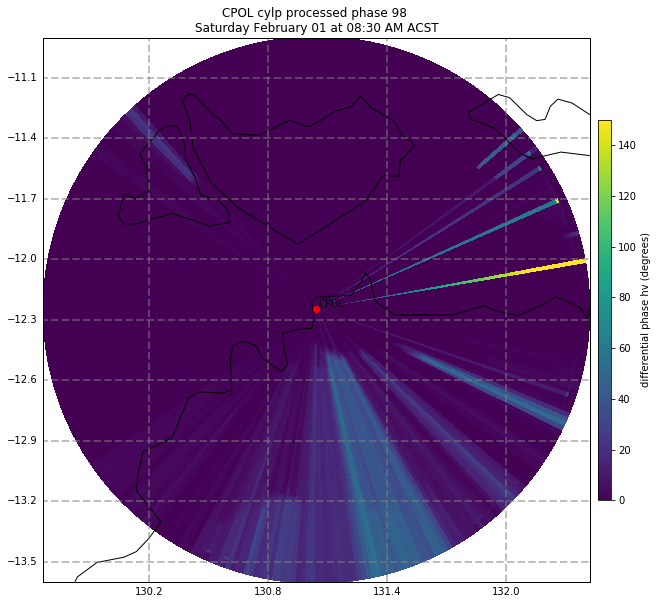

In [13]:
plot_radar_ppi(radar, field='cylp_processed_phase_98', vmin=0, vmax=150, sweep=1, name='CPOL')

In [14]:

std_dev = pyart.util.angular_texture_2d(radar.fields['PHIDP']['data'],
                                        4, 180)
filtered_data = scipy.ndimage.filters.median_filter(std_dev, size=(4, 4))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data

In [15]:
radar.add_field('phidp_texture', texture_field, replace_existing=True)

min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


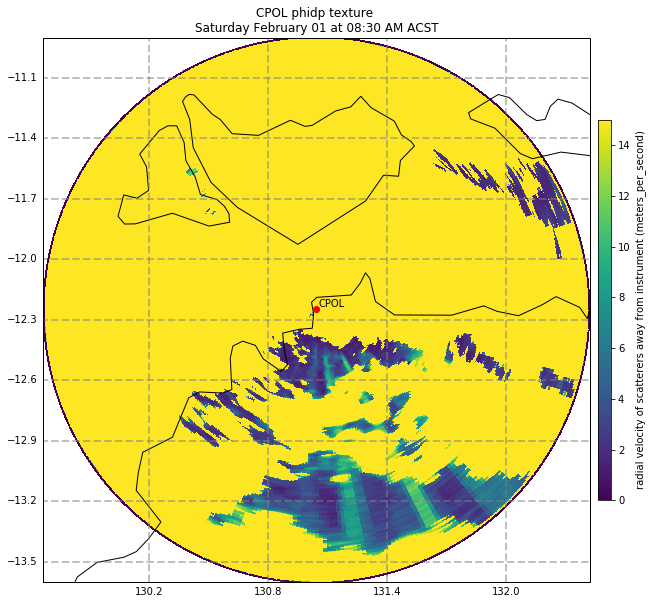

In [16]:
plot_radar_ppi(radar, field='phidp_texture', vmin=0, vmax=15, sweep=1, name='CPOL')

In [23]:
my_gatefilter = pyart.filters.GateFilter(radar)
my_gatefilter.exclude_above('phidp_texture', 13.5)

min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


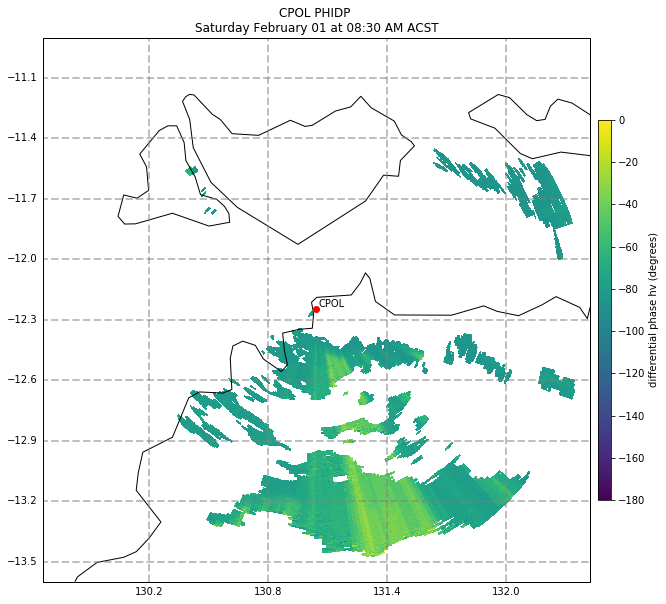

In [24]:
plot_radar_ppi(radar, field='PHIDP', vmin=-180, vmax=0, gatefilter=my_gatefilter, sweep=1, name='CPOL')

In [41]:
#Dodheville locally!
kdp_top = 5000.
coh_pwr = copy.deepcopy(radar.fields['PHIDP'])
coh_pwr['data'] = coh_pwr['data']*0.+1.
radar.fields['NCP'] = coh_pwr
phidp,kdp = phase_proc_lp_gf(radar,0.0, my_gatefilter,
                                      refl_field='DBZ',
                                      LP_solver='cylp',
                                      ncp_field='NCP',
                                      rhv_field='RHOHV',
                                      phidp_field='PHIDP',
                                      fzl = kdp_top,
                                      debug=True, min_rhv=.95,
                            ncpts=10)
radar.fields['cylp_processed_phase_gf'] = phidp
radar.fields['specific_differential_phase'] = kdp

Unfolding


/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:188: RuntimeWarning: invalid value encountered in sqrt
  noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:189: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / noise


Exec time:  15.49239706993103
Doing  0


/home/scollis/anaconda3/envs/pyart3x/lib/python3.6/site-packages/pyart/correct/phase_proc.py:589: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  sct[np.where(sct < 0.0)] = 0.0


Doing  1
Doing  2
Doing  3
Doing  4
Doing  5
Doing  6
Doing  7
Doing  8
Doing  9
Doing  10
Doing  11
Doing  12
Doing  13
Doing  14
Doing  15


min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


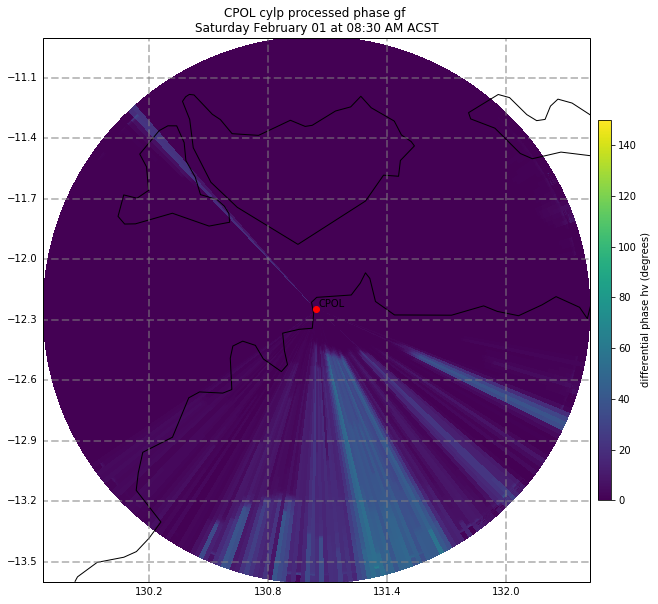

In [42]:
plot_radar_ppi(radar, field='cylp_processed_phase_gf', vmin=0, vmax=150, sweep=1, name='CPOL')

min_lat: -13.5975  min_lon: 129.664  max_lat: -10.9003  max_lon: 132.424
Saturday February 01 at 08:30 AM ACST


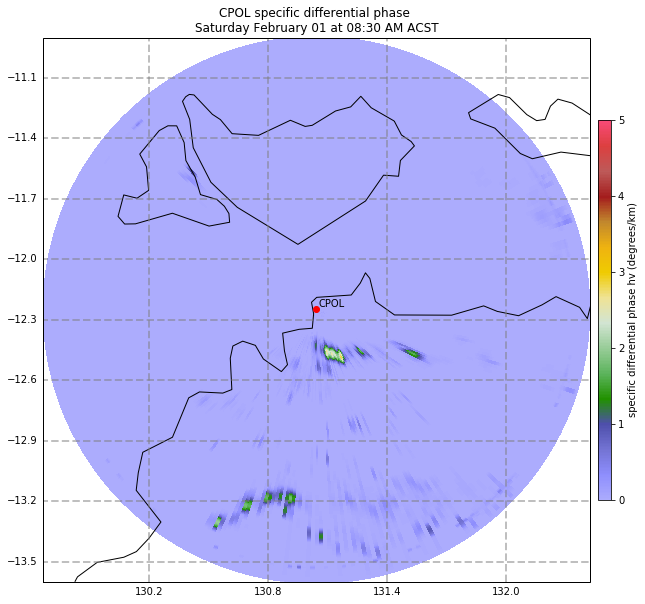

In [43]:
plot_radar_ppi(radar, field='specific_differential_phase', vmin=0, vmax=5, sweep=1, name='CPOL')